In [1]:
! rm -rf gpHSP
!git clone https://github.com/aspuru-guzik-group/gpHSP

Cloning into 'gpHSP'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 115 (delta 44), reused 57 (delta 24), pack-reused 38
Receiving objects: 100% (115/115), 32.19 MiB | 24.35 MiB/s, done.
Resolving deltas: 100% (58/58), done.


# Assuming in a colab enviroment

In [2]:
import sys
if 'google.colab' in sys.modules:
    print('In colab!')
    sys.path.insert(0,'gpHSP')
    !pip install rdkit-pypi mordred ml_collections ngboost gpflow

In colab!


In [3]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy.stats as stats

import sklearn.model_selection
import sklearn.preprocessing
import ngboost
import seaborn as sns
import tensorflow as tf
import gpflow as gpf
import gphsp
from gphsp import cast_1d_array

gphsp.notebook_context()
gphsp.print_modules([ngboost, tf , gpf])

ngboost    = 0.3.12
tensorflow = 2.7.0
gpflow     = 2.3.1


## Utilities

In [11]:
at_data_dir = lambda x: os.path.join('gpHSP/data', x)
at_model_dir = lambda x: os.path.join('gpHSP/models', x)

# Load data and get all smiles

In [5]:
df = pd.read_csv(at_data_dir('Solvents_exp.csv'))
df['smiles'] = df['smiles'].apply(gphsp.get_isomeric_smiles)
gphsp.peek_df(df)

Index(['key', 'Type', 'δd', 'δp', 'δh', 'smiles', 'ID_type', 'ID', 'Ref',
       'organic', 'n_electrons', 'n_atoms', 'charge', 'MolWt', 'label',
       'finished', 'job_name', 'homo', 'lumo', 'gap', 'd-moments', 'dipole',
       'polar', 'run_time', 'n_cores', 'compute_time', 'Area', 'Hba', 'Hbd',
       'Volume', 'sigma_mom_0', 'sigma_mom_1', 'sigma_mom_2', 'sigma_mom_3',
       'sigma_mom_4', 'sigma_mom_5', 'sigma_norm', 'sigma_profile', 'drug'],
      dtype='object')
(193, 39)


,key,Type,δd,δp,δh,smiles,ID_type,ID,Ref,organic,n_electrons,n_atoms,charge,MolWt,label,finished,job_name,homo,lumo,gap,d-moments,dipole,polar,run_time,n_cores,compute_time,Area,Hba,Hbd,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile,drug
0,"1,1,1-Trichloroethane",Solvent,16.8,4.3,2.0,CC(Cl)(Cl)Cl,CAS,71-55-6,1,True,32,5,0,133.405,Exp-0,True,SOLSPE_Exp-0,-7.097,-1.108,5.989,[-2.37335554 -0.11768285 0.07442233],2.377,64.374,94.214,4,376.856,1.326,0.0,0.0,0.126,0,16.6,-3.836,4.24,-2.021,1.54,41.428,[ 0. 0. 0. 0. ...,False


In [6]:
poly_df = pd.read_csv(at_data_dir('Polymers_exp.csv'))
poly_df['smiles'] = poly_df['smiles'].apply(gphsp.get_isomeric_smiles)
gphsp.peek_df(poly_df)

Index(['label', 'δd', 'δp', 'δh', 'smiles', 'test', 'poly_label', 'n_copies',
       'organic', 'n_electrons', 'n_atoms', 'charge', 'MolWt', 'n_frags',
       'largest', 'finished', 'job_name', 'poly_smiles', 'homo', 'lumo', 'gap',
       'd-moments', 'dipole', 'polar', 'run_time', 'n_cores', 'compute_time',
       'Area', 'Hba', 'Hbd', 'Volume', 'sigma_mom_0', 'sigma_mom_1',
       'sigma_mom_2', 'sigma_mom_3', 'sigma_mom_4', 'sigma_mom_5',
       'sigma_norm', 'sigma_profile'],
      dtype='object')
(31, 39)


,label,δd,δp,δh,smiles,test,poly_label,n_copies,organic,n_electrons,n_atoms,charge,MolWt,n_frags,largest,finished,job_name,poly_smiles,homo,lumo,gap,d-moments,dipole,polar,run_time,n_cores,compute_time,Area,Hba,Hbd,Volume,sigma_mom_0,sigma_mom_1,sigma_mom_2,sigma_mom_3,sigma_mom_4,sigma_mom_5,sigma_norm,sigma_profile
0,Polyacrylonitrile-n5,20.0,15.1,7.9,CCC#N,True,Polyacrylonitrile,5,True,110,45,0,275.4,1,True,True,SOLSPE2_Polyacrylonitrile-n5,[C@@H](C#N)(CCC#N)C[C@@H](C#N)C[C@H](C#N)CCC#N,-7.879,-1.12,6.759,[ 0.58302575 -8.49403297 -1.86749721],8.716,211.624,468.596,4,1874.384,3.047,1.539,0.22,0.343,0,175.0,26.1,154.0,51.4,165.0,66.77,[ 0. 0. 0. 0. ...


Load features

In [7]:
features = gphsp.SmilesMap(at_data_dir('mordred_features.npz'))

# Train rfHSP model on single molecules

In [35]:
results = []
x = features(df['smiles'].to_numpy(str)).astype(np.float64)
n_splits = 5
indices = np.arange(len(x))
names = gphsp.Y_COLS
for name in tqdm(names, total=len(names)):
    y = df[name].to_numpy(np.float64).reshape(-1,1)
    spliter = sklearn.model_selection.KFold(n_splits, shuffle=True, random_state=42)
    y_mean_rf, y_mean_gp = np.zeros_like(indices), np.zeros_like(indices)
    y_std_rf, y_std_gp = np.zeros_like(indices), np.zeros_like(indices)
    for train_index, test_index in tqdm(spliter.split(indices), total=n_splits):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = ngboost.NGBRegressor().fit(x_train, y_train.ravel())
        y_dists = model.pred_dist(x_test)
        y_mean_rf[test_index] = y_dists.mean().ravel()
        y_std_rf[test_index] = y_dists.std().ravel()

        # Standarize target
        preproc = sklearn.preprocessing.StandardScaler()
        y_train = preproc.fit_transform(y_train)     

        model = gphsp.make_gp(x_train, y_train, False, None)
        y_mu, y_std = model.predict_f(x_test)
        y_mean_gp[test_index] = cast_1d_array(preproc.inverse_transform(y_mu.numpy()))
        y_std_gp[test_index] = cast_1d_array(y_std)*preproc.scale_

    results.append(gphsp.evaluate(y, y_mean_rf, y_std_rf, {'name':name, 'method':'ngboost'}))
    results.append(gphsp.evaluate(y, y_mean_gp, y_std_gp, {'name':name, 'method':'gp'}))
    display(pd.DataFrame(results[-2:]))

results_df = pd.DataFrame(results)
results_df

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=2.0688 val_loss=0.0000 scale=1.0000 norm=1.6247
[iter 100] loss=1.3792 val_loss=0.0000 scale=2.0000 norm=1.7279
[iter 200] loss=0.7340 val_loss=0.0000 scale=2.0000 norm=1.1651
[iter 300] loss=0.2134 val_loss=0.0000 scale=1.0000 norm=0.4620
[iter 400] loss=-0.1289 val_loss=0.0000 scale=1.0000 norm=0.3990
[iter 0] loss=2.0192 val_loss=0.0000 scale=1.0000 norm=1.5470
[iter 100] loss=1.2761 val_loss=0.0000 scale=1.0000 norm=0.7993
[iter 200] loss=0.6790 val_loss=0.0000 scale=2.0000 norm=1.1282
[iter 300] loss=0.2127 val_loss=0.0000 scale=1.0000 norm=0.4599
[iter 400] loss=-0.1204 val_loss=0.0000 scale=1.0000 norm=0.3992
[iter 0] loss=2.0605 val_loss=0.0000 scale=1.0000 norm=1.6099
[iter 100] loss=1.2560 val_loss=0.0000 scale=2.0000 norm=1.5538
[iter 200] loss=0.5433 val_loss=0.0000 scale=2.0000 norm=1.0546
[iter 300] loss=-0.0111 val_loss=0.0000 scale=2.0000 norm=0.8439
[iter 400] loss=-0.3709 val_loss=0.0000 scale=1.0000 norm=0.3690
[iter 0] loss=1.9760 val_loss=0.0000 scale

,name,method,R2,MAE,tau,uncertainty_tau
0,δd,ngboost,0.303,1.046,0.583,NaN
1,δd,gp,-0.012,1.412,-0.064,NaN


  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=3.0512 val_loss=0.0000 scale=1.0000 norm=4.1291
[iter 100] loss=2.4740 val_loss=0.0000 scale=1.0000 norm=2.2662
[iter 200] loss=1.8780 val_loss=0.0000 scale=2.0000 norm=2.5890
[iter 300] loss=1.3008 val_loss=0.0000 scale=1.0000 norm=0.9096
[iter 400] loss=0.8704 val_loss=0.0000 scale=1.0000 norm=0.7272
[iter 0] loss=3.0900 val_loss=0.0000 scale=1.0000 norm=4.2681
[iter 100] loss=2.4715 val_loss=0.0000 scale=1.0000 norm=2.2474
[iter 200] loss=1.8785 val_loss=0.0000 scale=2.0000 norm=2.5586
[iter 300] loss=1.3489 val_loss=0.0000 scale=2.0000 norm=1.7768
[iter 400] loss=1.0292 val_loss=0.0000 scale=1.0000 norm=0.7235
[iter 0] loss=3.0941 val_loss=0.0000 scale=1.0000 norm=4.1960
[iter 100] loss=2.4755 val_loss=0.0000 scale=1.0000 norm=2.2681
[iter 200] loss=1.8049 val_loss=0.0000 scale=2.0000 norm=2.4639
[iter 300] loss=1.2131 val_loss=0.0000 scale=1.0000 norm=0.8677
[iter 400] loss=0.8508 val_loss=0.0000 scale=1.0000 norm=0.7196
[iter 0] loss=3.0850 val_loss=0.0000 scale=1.0

,name,method,R2,MAE,tau,uncertainty_tau
0,δp,ngboost,0.503,2.530,0.610,0.138
1,δp,gp,-0.024,4.126,-0.069,-0.015


  0%|          | 0/5 [00:00<?, ?it/s]

[iter 0] loss=3.2078 val_loss=0.0000 scale=1.0000 norm=4.7793
[iter 100] loss=2.2799 val_loss=0.0000 scale=2.0000 norm=3.2954
[iter 200] loss=1.5176 val_loss=0.0000 scale=2.0000 norm=1.9063
[iter 300] loss=0.8680 val_loss=0.0000 scale=2.0000 norm=1.4474
[iter 400] loss=0.4287 val_loss=0.0000 scale=1.0000 norm=0.6162
[iter 0] loss=3.1454 val_loss=0.0000 scale=1.0000 norm=4.6482
[iter 100] loss=2.2995 val_loss=0.0000 scale=2.0000 norm=3.2669
[iter 200] loss=1.4898 val_loss=0.0000 scale=2.0000 norm=1.6703
[iter 300] loss=0.7864 val_loss=0.0000 scale=2.0000 norm=1.1698
[iter 400] loss=0.3486 val_loss=0.0000 scale=1.0000 norm=0.4818
[iter 0] loss=3.1566 val_loss=0.0000 scale=1.0000 norm=4.6127
[iter 100] loss=2.3468 val_loss=0.0000 scale=2.0000 norm=3.5918
[iter 200] loss=1.5463 val_loss=0.0000 scale=2.0000 norm=1.9141
[iter 300] loss=0.8886 val_loss=0.0000 scale=2.0000 norm=1.4523
[iter 400] loss=0.4311 val_loss=0.0000 scale=1.0000 norm=0.6058
[iter 0] loss=3.1856 val_loss=0.0000 scale=1.0

,name,method,R2,MAE,tau,uncertainty_tau
0,δh,ngboost,0.691,2.037,0.735,0.052
1,δh,gp,0.005,4.616,0.119,-0.023


,name,method,R2,MAE,tau,uncertainty_tau
0,δd,ngboost,0.303,1.046,0.583,NaN
1,δd,gp,-0.012,1.412,-0.064,NaN
2,δp,ngboost,0.503,2.530,0.610,0.138
3,δp,gp,-0.024,4.126,-0.069,-0.015
4,δh,ngboost,0.691,2.037,0.735,0.052
5,δh,gp,0.005,4.616,0.119,-0.023


In [38]:
results_df = pd.DataFrame(results)
results_df

,name,method,R2,MAE,tau,uncertainty_tau
0,δd,ngboost,0.303,1.046,0.583,NaN
1,δd,gp,-0.012,1.412,-0.064,NaN
2,δp,ngboost,0.503,2.530,0.610,0.138
3,δp,gp,-0.024,4.126,-0.069,-0.015
4,δh,ngboost,0.691,2.037,0.735,0.052
5,δh,gp,0.005,4.616,0.119,-0.023


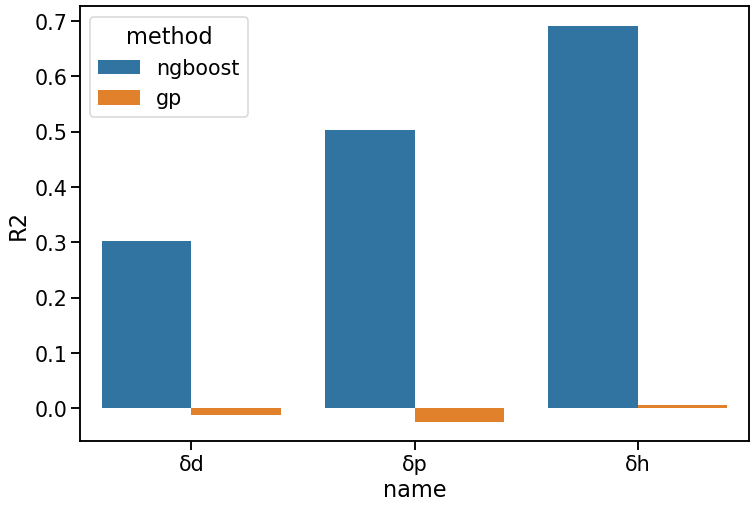

In [39]:
sns.barplot(x='name', y='R2', hue='method', data=results_df)

# Train gpHSP model on polymers

In [14]:
def predictions_as_features(x, model_dict, pred_fn=None):
    default_pred_fn = lambda model, inputs: model.pred_dist(inputs)
    pred_fn = pred_fn or default_pred_fn
    new_x = np.zeros((len(x), 6), dtype=np.float64)
    for index, name in enumerate(names):
        y_mol_dist = pred_fn(models[name], x)
        new_x[:,index] = y_mol_dist.mean()
        new_x[:,index+3] = y_mol_dist.mean()
    return new_x


In [24]:
model_suffix = 'HSP_ngboost_mol.pkl'
names = gphsp.Y_COLS
models = {name: gphsp.load_model(at_model_dir(f"{name}_{model_suffix}")) for name in names}
mol_x = features(poly_df['smiles'].to_numpy(str)).astype(np.float64)
x = predictions_as_features(mol_x, models)

In [35]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

results = []
indices = np.arange(len(x))
n_splits = len(indices)
names = gphsp.Y_COLS
gp_parts = {'mean':[0,1, 2], 'std':[3, 4, 5]}

for index, name in tqdm(enumerate(names), total=len(names)):
    y = poly_df[name].to_numpy(np.float64).reshape(-1,1)
    spliter = sklearn.model_selection.LeaveOneOut()
    y_mean_rf, y_std_rf = np.zeros_like(indices), np.zeros_like(indices)
    y_mean_mol, y_std_mol = np.zeros_like(indices), np.zeros_like(indices)
    y_mean_gp, y_std_gp = np.zeros_like(indices), np.zeros_like(indices)
    y_mean_lin = np.zeros_like(indices)

    for train_index, test_index in tqdm(spliter.split(indices), total=n_splits):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #RF model
        model = ngboost.NGBRegressor().fit(x_train, y_train.ravel())
        y_dists = model.pred_dist(x_test)
        y_mean_rf[test_index] = y_dists.mean().ravel()
        y_std_rf[test_index] = y_dists.std().ravel()

        # Linear model
        x_train, x_test = mol_x[train_index], mol_x[test_index]
        model = sklearn.linear_model.LassoCV()
        model.fit(x_train, y_train.ravel())
        y_mu = model.predict(x_test)
        y_mean_lin[test_index] = cast_1d_array(y_mu)

        # Standarize target
        #preproc = sklearn.preprocessing.StandardScaler()
        #y_train = preproc.fit_transform(y_train)     

        model = gphsp.make_gp(x_train, y_train, True, gp_parts)
        y_mu, y_std = model.predict_f(x_test)
        y_mean_gp[test_index] = cast_1d_array(y_mu)
        y_std_gp[test_index] = cast_1d_array(y_std)

        x_train, x_test = mol_x[train_index], mol_x[test_index]
        model = gphsp.make_gp(x_train, y_train, False, None)
        y_mu, y_std = model.predict_f(x_test)
        y_mean_mol[test_index] = cast_1d_array(y_mu)
        y_std_mol[test_index] = cast_1d_array(y_std)


    results.append(gphsp.evaluate(y, y_mean_rf, y_std_rf, {'name':name, 'method':'ngboost', 'feature':'HSP'}))
    results.append(gphsp.evaluate(y, y_mean_gp, y_std_gp, {'name':name, 'method':'gp', 'feature':'HSP'}))
    results.append(gphsp.evaluate(y, y_mean_mol, y_std_mol, {'name':name, 'method':'gp', 'feature':'mol'}))
    results.append(gphsp.evaluate(y, y_mean_lin, info={'name':name, 'method':'linear', 'feature':'mol'}))
    display(pd.DataFrame(results[-4:]))
results_df = pd.DataFrame(results)
gphsp.peek_df(results_df)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

[iter 0] loss=1.2244 val_loss=0.0000 scale=1.0000 norm=0.8618
[iter 100] loss=0.6321 val_loss=0.0000 scale=2.0000 norm=1.0853
[iter 200] loss=-0.2056 val_loss=0.0000 scale=2.0000 norm=0.8889
[iter 300] loss=-0.9857 val_loss=0.0000 scale=1.0000 norm=0.4140
[iter 400] loss=-1.6566 val_loss=0.0000 scale=1.0000 norm=0.3931
[iter 0] loss=1.2684 val_loss=0.0000 scale=1.0000 norm=0.8951
[iter 100] loss=0.6232 val_loss=0.0000 scale=2.0000 norm=1.0979
[iter 200] loss=-0.1909 val_loss=0.0000 scale=2.0000 norm=0.8831
[iter 300] loss=-0.9552 val_loss=0.0000 scale=2.0000 norm=0.8067
[iter 400] loss=-1.7041 val_loss=0.0000 scale=2.0000 norm=0.7761
[iter 0] loss=1.3034 val_loss=0.0000 scale=1.0000 norm=0.9155
[iter 100] loss=0.6824 val_loss=0.0000 scale=1.0000 norm=0.5632
[iter 200] loss=-0.1302 val_loss=0.0000 scale=2.0000 norm=0.8841
[iter 300] loss=-0.8615 val_loss=0.0000 scale=2.0000 norm=0.7780
[iter 400] loss=-1.5617 val_loss=0.0000 scale=2.0000 norm=0.7227
[iter 0] loss=1.2975 val_loss=0.0000 

,name,method,feature,R2,MAE,tau,uncertainty_tau
0,δd,ngboost,HSP,-0.111,0.773,0.473,NaN
1,δd,gp,HSP,-0.452,0.829,0.344,NaN
2,δd,gp,mol,0.040,0.709,0.256,-0.204
3,δd,linear,mol,-0.652,0.918,-0.051,NaN


  0%|          | 0/31 [00:00<?, ?it/s]

[iter 0] loss=2.7972 val_loss=0.0000 scale=1.0000 norm=3.3813
[iter 100] loss=1.9975 val_loss=0.0000 scale=2.0000 norm=2.5517
[iter 200] loss=1.2245 val_loss=0.0000 scale=2.0000 norm=1.4846
[iter 300] loss=0.5459 val_loss=0.0000 scale=2.0000 norm=1.1265
[iter 400] loss=-0.0108 val_loss=0.0000 scale=1.0000 norm=0.4850
[iter 0] loss=2.8317 val_loss=0.0000 scale=1.0000 norm=3.5259
[iter 100] loss=2.0071 val_loss=0.0000 scale=2.0000 norm=2.5241
[iter 200] loss=1.1629 val_loss=0.0000 scale=2.0000 norm=1.3547
[iter 300] loss=0.4072 val_loss=0.0000 scale=2.0000 norm=1.0852
[iter 400] loss=-0.2126 val_loss=0.0000 scale=1.0000 norm=0.4749
[iter 0] loss=2.8211 val_loss=0.0000 scale=1.0000 norm=3.5022
[iter 100] loss=2.0090 val_loss=0.0000 scale=2.0000 norm=2.5286
[iter 200] loss=1.1643 val_loss=0.0000 scale=2.0000 norm=1.3529
[iter 300] loss=0.4087 val_loss=0.0000 scale=2.0000 norm=1.0861
[iter 400] loss=-0.1812 val_loss=0.0000 scale=2.0000 norm=0.9647
[iter 0] loss=2.8665 val_loss=0.0000 scale=

,name,method,feature,R2,MAE,tau,uncertainty_tau
0,δp,ngboost,HSP,0.241,2.718,0.435,0.221
1,δp,gp,HSP,-0.146,3.462,-0.033,-0.333
2,δp,gp,mol,0.031,3.269,0.266,-0.428
3,δp,linear,mol,0.055,3.067,0.250,NaN


  0%|          | 0/31 [00:00<?, ?it/s]

[iter 0] loss=2.9031 val_loss=0.0000 scale=1.0000 norm=3.3796
[iter 100] loss=1.9001 val_loss=0.0000 scale=2.0000 norm=2.4607
[iter 200] loss=1.1900 val_loss=0.0000 scale=2.0000 norm=1.6279
[iter 300] loss=0.6060 val_loss=0.0000 scale=1.0000 norm=0.6476
[iter 400] loss=0.0485 val_loss=0.0000 scale=1.0000 norm=0.5590
[iter 0] loss=2.8897 val_loss=0.0000 scale=1.0000 norm=3.3140
[iter 100] loss=1.8960 val_loss=0.0000 scale=2.0000 norm=2.4401
[iter 200] loss=1.1307 val_loss=0.0000 scale=2.0000 norm=1.5204
[iter 300] loss=0.4013 val_loss=0.0000 scale=2.0000 norm=1.2133
[iter 400] loss=-0.2637 val_loss=0.0000 scale=2.0000 norm=1.0550
[iter 0] loss=2.8733 val_loss=0.0000 scale=1.0000 norm=3.2658
[iter 100] loss=1.8860 val_loss=0.0000 scale=2.0000 norm=2.4230
[iter 200] loss=1.1298 val_loss=0.0000 scale=2.0000 norm=1.5331
[iter 300] loss=0.4132 val_loss=0.0000 scale=2.0000 norm=1.2198
[iter 400] loss=-0.2538 val_loss=0.0000 scale=2.0000 norm=1.0641
[iter 0] loss=2.8943 val_loss=0.0000 scale=1

InvalidArgumentError: ignored